In [1]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.7 MB/s eta 0:00:00


# Without Lora

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

DualEncoderModelWithoutLoRA(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Best model saved at epoch 1 with validation loss: 0.6326066851615906
Epoch 1, Train Loss: 0.6359233307459998, Validation Loss: 0.6326066851615906
Epoch 2
Best model saved at epoch 2 with validation loss: 0.620964697429112
Epoch 2, Train Loss: 0.5913640194469028, Validation Loss: 0.620964697429112
Epoch 3
Best model saved at epoch 3 with validation loss: 0.6013902127742767
Epoch 3, Train Loss: 0.5150041887684474, Validation Loss: 0.6013902127742767
Epoch 4
Best model saved at epoch 4 with validation loss: 0.5900602510997227
Epoch 4, Train Loss: 0.4804535891328539, Validation Loss: 0.5900602510997227
Epoch 5
Epoch 5, Train Loss: 0.4498489953222729, Validation Loss: 0.5913811028003693
Epoch 6
Best model saved at epoch 6 with validation loss: 0.5794113533837455
Epoch 6, Train Loss: 0.4272801663194384, Validation Loss: 0.5794113533837455
Epoch 7
Epoch 7, Train Loss: 0.4064380554925828, Validation Loss: 0.5881137890475137
Epoch 8
Epoch 8, Train Loss: 0.39537131549820065, Validation L

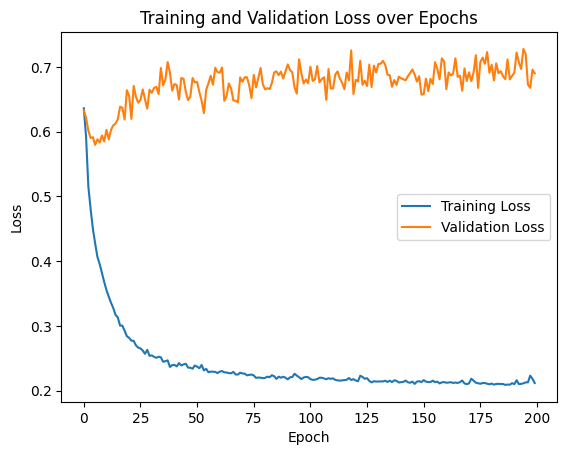

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW
from peft import LoraConfig, get_peft_model, TaskType

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import pandas as pd

file_path = '/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train.tsv'
file_path = '/kaggle/input/anlp-proj/subtask_a_train.tsv'

df = pd.read_csv(file_path, sep='\t')

df.head()

import ast
def arrange_sentences(df):
    captions_ordered = []   
    
    for i in range(len(df)):
        order = df['expected_order'][i]
        image1_name = df['image1_name'].values[i]
        image2_name = df['image2_name'].values[i]
        image3_name = df['image3_name'].values[i]
        image4_name = df['image4_name'].values[i]
        image5_name = df['image5_name'].values[i]
        
        captions = []
        order = ast.literal_eval(order)
        for j in range(len(order)):
            image_name = order[j]
            if image_name == image1_name:
                captions.append(df['image1_caption'].values[i])
            elif image_name == image2_name:
                captions.append(df['image2_caption'].values[i])
            elif image_name == image3_name:
                captions.append(df['image3_caption'].values[i])
            elif image_name == image4_name:
                captions.append(df['image4_caption'].values[i])
            elif image_name == image5_name:
                captions.append(df['image5_caption'].values[i])
        captions_ordered.append(captions)

    return captions_ordered

captions_ordered = arrange_sentences(df)
df['captions_ordered'] = captions_ordered
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class AdMireDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        compound = self.df.iloc[idx]['compound']
        sentence = self.df.iloc[idx]['sentence']
        captions = [
            self.df.iloc[idx]['image1_caption'],
            self.df.iloc[idx]['image2_caption'],
            self.df.iloc[idx]['image3_caption'],
            self.df.iloc[idx]['image4_caption'],
            self.df.iloc[idx]['image5_caption']
        ]

        caption1 = self.df.iloc[idx]['image1_caption']
        caption2 = self.df.iloc[idx]['image2_caption']
        caption3 = self.df.iloc[idx]['image3_caption']
        caption4 = self.df.iloc[idx]['image4_caption']
        caption5 = self.df.iloc[idx]['image5_caption']
        expected_order = self.df.iloc[idx]['captions_ordered']
        expected_order_indices = []
        for i in range(len(expected_order)):
            s = expected_order[i]
            if s == caption1:
                expected_order_indices.append(1)
            elif s == caption2:
                expected_order_indices.append(2)
            elif s == caption3:
                expected_order_indices.append(3)
            elif s == caption4:
                expected_order_indices.append(4)
            elif s == caption5:
                expected_order_indices.append(5)

        sentence = sentence.replace(compound, '[SEP] ' + compound + ' [SEP]')
        captions = [cap.replace(compound, '[SEP] ' + compound + ' [SEP]') for cap in captions]

        sentence_tokens = self.tokenizer(sentence, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        caption_tokens = [self.tokenizer(cap, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt') for cap in captions]

        num_compound_words = len(compound.split(' '))
        compound_position = torch.tensor(
            (sentence_tokens['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words),
            device=device  # Move to the correct device (GPU or CPU)
        )

        caption_positions = torch.tensor(
            [(cap['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words) for cap in caption_tokens],
            device=device  # Make sure the tensor is moved to the correct device (GPU or CPU)
        )


        expected_order_indices = np.array(expected_order_indices)
        expected_order_indices = torch.tensor(expected_order_indices, device = device)

        return sentence_tokens, caption_tokens, expected_order_indices, compound_position, caption_positions


class DualEncoderModelWithoutLoRA(nn.Module):
    def __init__(self):
        super(DualEncoderModelWithoutLoRA, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Add a BiLSTM layer
        self.bilstm = nn.LSTM(
            input_size=768,          # BERT's hidden size
            hidden_size=64,         # LSTM's hidden size
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, sentence_tokens, caption_tokens, compound_position, caption_positions):

        # Process sentence tokens
        sentence_tokens = {k: v.squeeze(0) for k, v in sentence_tokens.items()}
        sentence_outputs = self.bert(**sentence_tokens)
        
        # Pass BERT outputs through BiLSTM
        sentence_lstm_outputs, _ = self.bilstm(sentence_outputs.last_hidden_state)
        sentence_embedding = sentence_lstm_outputs.mean(dim=1).squeeze(0)  # Shape: (512,)

        # Process caption tokens
        caption_embeddings = []
        for cap_tokens in caption_tokens:
            cap_tokens = {k: v.squeeze(0) for k, v in cap_tokens.items()}
            cap_outputs = self.bert(**cap_tokens)
            cap_lstm_outputs, _ = self.bilstm(cap_outputs.last_hidden_state)
            cap_embedding = cap_lstm_outputs.mean(dim=1).squeeze(0)  # Shape: (512,)
            caption_embeddings.append(cap_embedding)
        
        return sentence_embedding, caption_embeddings


model = DualEncoderModelWithoutLoRA().to(device)


print(model)



class RankingTripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingTripletLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=0)
    
    def forward(self, sentence_embedding, caption_embeddings, expected_order):
        loss = 0.0
        num_triplets = 0

        expected_order = expected_order[0]
        

        for i in range(len(expected_order) - 1):
            for j in range(i + 1, len(expected_order)):
                pos = caption_embeddings[expected_order[i] - 1]
                neg = caption_embeddings[expected_order[j] - 1]

                
                try:
                    d_pos = self.cosine_similarity(sentence_embedding, pos)
                    d_neg = self.cosine_similarity(sentence_embedding, neg)
                    
                    weight = 1.0 / abs(i - j)
                    triplet_loss = weight * torch.relu(d_neg - d_pos + self.margin)
                    
                    loss += triplet_loss
                    num_triplets += 1
                except:
                    pass

        loss = loss / num_triplets if num_triplets > 0 else 0.0
        return loss.mean()

from torch.utils.data import DataLoader, random_split


best_val_loss = float('inf')
best_model_path = 'best_model_without_lora_64.pth'


dataset = AdMireDataset(df)


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
# Split the dataset indices
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

# Create Subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


train_loader = DataLoader(
    train_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=True,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)

val_loader = DataLoader(
    val_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=False,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)



# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = RankingTripletLoss(margin=1.0)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    print(f"Epoch {epoch + 1}")

    for batch in train_loader:
        sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch
        sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
        caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
        expected_order, compound_positions, caption_positions = expected_order.to(device), compound_positions.to(device), caption_positions.to(device)

        sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
        loss = criterion(sentence_embedding, caption_embeddings, expected_order)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch
            sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
            caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
            expected_order, compound_positions, caption_positions = expected_order.to(device), compound_positions.to(device), caption_positions.to(device)

            sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
            loss = criterion(sentence_embedding, caption_embeddings, expected_order)
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))


    avg_val_loss = val_losses[-1]
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss}")

    

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [3]:
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn.functional as F

# Define a function to calculate Spearman's rank correlation
def calculate_spearman(expected, predicted):
    # Convert expected and predicted to a ranking index list
    return spearmanr(expected, predicted).correlation

# Define a function to calculate Kendall's Tau correlation
def calculate_kendall_tau(expected, predicted):
    return kendalltau(expected, predicted).correlation

# Define a function to calculate Mean Reciprocal Rank (MRR)
def calculate_mrr(expected, predicted):
    # Find the position of the first relevant item in the predicted list
    ranks = {v: i + 1 for i, v in enumerate(predicted)}
    reciprocal_rank = 0
    for item in expected:
        if item in ranks:
            reciprocal_rank += 1 / ranks[item]
    return reciprocal_rank / len(expected)  # Averaging over all expected items

# Function to calculate Top-1 accuracy
def top_1_accuracy(expected, predicted):
    return int(expected[0] == predicted[0])

def calc_spearman_acc(model, dataloader):
    spearman = []
    kendall = []
    mrr = []
    top_1 = []
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in dataloader:
            sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch

            # Move tensors to device
            sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
            caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
            expected_order = expected_order.to(device)
            compound_positions = compound_positions.to(device)
            caption_positions = caption_positions.to(device)

            # Forward pass
            sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)

            try:
                similarities = []
                for i in range(len(caption_embeddings)):
                    tensor1 = sentence_embedding
                    tensor2 = caption_embeddings[i]
                    similarity = F.cosine_similarity(tensor1.unsqueeze(0), tensor2.unsqueeze(0), dim=1)
                    similarities.append(similarity.mean())
                
                similarities = torch.stack(similarities)
                ranked_indices = torch.argsort(similarities, descending=True)
                
                predicted_order = [x.item() + 1 for x in ranked_indices]
                e_o = [x.item() for x in expected_order[0]]

                # Calculate metrics
                spearman.append(calculate_spearman(e_o, predicted_order))
                kendall.append(calculate_kendall_tau(e_o, predicted_order))
                mrr.append(calculate_mrr(e_o, predicted_order))
                top_1.append(top_1_accuracy(e_o, predicted_order))
            
            except:
                continue  # Skip if there is an error

    return spearman, kendall, mrr, top_1

In [4]:
model.load_state_dict(torch.load(best_model_path))
spearman, kendall, mrr, top_1 = calc_spearman_acc(model, train_loader)

print("Spearman Correlation:", sum(spearman) / len(spearman))
print("Kendall's Tau:", sum(kendall) / len(kendall))
print("Mean Reciprocal Rank (MRR):", sum(mrr) / len(mrr))
print("Top-1 Accuracy:", sum(top_1) / len(top_1))


/tmp/ipykernel_23/3357228837.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Spearman Correlation: 0.4063492063492063
Kendall's Tau: 0.3523809523809524
Mean Reciprocal Rank (MRR): 0.45666666666666694
Top-1 Accuracy: 0.7301587301587301


In [5]:
spearman, kendall, mrr, top_1 = calc_spearman_acc(model, val_loader)

print("Spearman Correlation:", sum(spearman) / len(spearman))
print("Kendall's Tau:", sum(kendall) / len(kendall))
print("Mean Reciprocal Rank (MRR):", sum(mrr) / len(mrr))
print("Top-1 Accuracy:", sum(top_1) / len(top_1))

Spearman Correlation: -0.23775544194954779
Kendall's Tau: -0.15946110943097686
Mean Reciprocal Rank (MRR): 0.45428571428571424
Top-1 Accuracy: 0.42857142857142855


In [6]:
# Define a function to count trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print the total number of trainable parameters
total_params = count_trainable_parameters(model)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 526336


# with lora

DualEncoderModelWithLoRA(
  (bert): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Best model saved at epoch 1 with validation loss: 0.6264040725571769
Epoch 1, Train Loss: 0.6235317644618806, Validation Loss: 0.6264040725571769
Epoch 2
Best model saved at epoch 2 with validation loss: 0.5916268570082528
Epoch 2, Train Loss: 0.534790101978514, Validation Loss: 0.5916268570082528
Epoch 3
Best model saved at epoch 3 with validation loss: 0.5615786399160113
Epoch 3, Train Loss: 0.4650326073169708, Validation Loss: 0.5615786399160113
Epoch 4
Best model saved at epoch 4 with validation loss: 0.5520357319286892
Epoch 4, Train Loss: 0.4187141391966078, Validation Loss: 0.5520357319286892
Epoch 5
Epoch 5, Train Loss: 0.3893717801760113, Validation Loss: 0.5615779204027993
Epoch 6
Epoch 6, Train Loss: 0.3545890587662894, Validation Loss: 0.5591764492647988
Epoch 7
Epoch 7, Train Loss: 0.33379422530295355, Validation Loss: 0.5678355353219169
Epoch 8
Epoch 8, Train Loss: 0.31493358668826876, Validation Loss: 0.5707975668566567
Epoch 9
Epoch 9, Train Loss: 0.300764315185

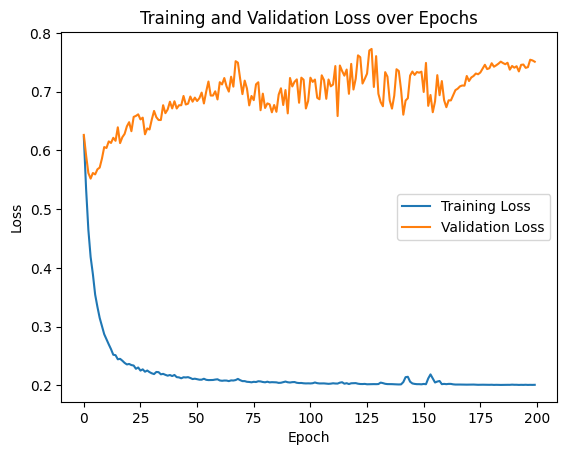

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW
from peft import LoraConfig, get_peft_model, TaskType

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import pandas as pd

file_path = '/kaggle/input/admire-task-a/AdMIRe Subtask A Train/train/subtask_a_train.tsv'
file_path = '/kaggle/input/anlp-proj/subtask_a_train.tsv'

df = pd.read_csv(file_path, sep='\t')

df.head()

import ast
def arrange_sentences(df):
    captions_ordered = []   
    
    for i in range(len(df)):
        order = df['expected_order'][i]
        image1_name = df['image1_name'].values[i]
        image2_name = df['image2_name'].values[i]
        image3_name = df['image3_name'].values[i]
        image4_name = df['image4_name'].values[i]
        image5_name = df['image5_name'].values[i]
        
        captions = []
        order = ast.literal_eval(order)
        for j in range(len(order)):
            image_name = order[j]
            if image_name == image1_name:
                captions.append(df['image1_caption'].values[i])
            elif image_name == image2_name:
                captions.append(df['image2_caption'].values[i])
            elif image_name == image3_name:
                captions.append(df['image3_caption'].values[i])
            elif image_name == image4_name:
                captions.append(df['image4_caption'].values[i])
            elif image_name == image5_name:
                captions.append(df['image5_caption'].values[i])
        captions_ordered.append(captions)

    return captions_ordered

captions_ordered = arrange_sentences(df)
df['captions_ordered'] = captions_ordered
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class AdMireDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        compound = self.df.iloc[idx]['compound']
        sentence = self.df.iloc[idx]['sentence']
        captions = [
            self.df.iloc[idx]['image1_caption'],
            self.df.iloc[idx]['image2_caption'],
            self.df.iloc[idx]['image3_caption'],
            self.df.iloc[idx]['image4_caption'],
            self.df.iloc[idx]['image5_caption']
        ]

        caption1 = self.df.iloc[idx]['image1_caption']
        caption2 = self.df.iloc[idx]['image2_caption']
        caption3 = self.df.iloc[idx]['image3_caption']
        caption4 = self.df.iloc[idx]['image4_caption']
        caption5 = self.df.iloc[idx]['image5_caption']
        expected_order = self.df.iloc[idx]['captions_ordered']
        expected_order_indices = []
        for i in range(len(expected_order)):
            s = expected_order[i]
            if s == caption1:
                expected_order_indices.append(1)
            elif s == caption2:
                expected_order_indices.append(2)
            elif s == caption3:
                expected_order_indices.append(3)
            elif s == caption4:
                expected_order_indices.append(4)
            elif s == caption5:
                expected_order_indices.append(5)

        sentence = sentence.replace(compound, '[SEP] ' + compound + ' [SEP]')
        captions = [cap.replace(compound, '[SEP] ' + compound + ' [SEP]') for cap in captions]

        sentence_tokens = self.tokenizer(sentence, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        caption_tokens = [self.tokenizer(cap, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt') for cap in captions]

        num_compound_words = len(compound.split(' '))
        compound_position = torch.tensor(
            (sentence_tokens['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words),
            device=device  # Move to the correct device (GPU or CPU)
        )

        caption_positions = torch.tensor(
            [(cap['input_ids'][0].tolist().index(self.tokenizer.convert_tokens_to_ids('[SEP]')) + 1 , num_compound_words) for cap in caption_tokens],
            device=device  # Make sure the tensor is moved to the correct device (GPU or CPU)
        )


        expected_order_indices = np.array(expected_order_indices)
        expected_order_indices = torch.tensor(expected_order_indices, device = device)

        return sentence_tokens, caption_tokens, expected_order_indices, compound_position, caption_positions



from peft import LoraConfig, get_peft_model, TaskType

class DualEncoderModelWithLoRA(nn.Module):
    def __init__(self):
        super(DualEncoderModelWithLoRA, self).__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Apply LoRA to the BERT model with correct task type
        lora_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,  # Changed task type
            inference_mode=False,
            r=8,                          # Rank of LoRA matrices
            lora_alpha=32,                # Scaling factor
            lora_dropout=0.1              # Dropout for LoRA layers
        )

        # Wrap the BERT model with LoRA
        self.bert = get_peft_model(self.bert, lora_config)

        # Add a BiLSTM layer
        self.bilstm = nn.LSTM(
            input_size=768,          # BERT's hidden size
            hidden_size=64,         # LSTM's hidden size
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, sentence_tokens, caption_tokens, compound_position, caption_positions):

        # Process sentence tokens
        sentence_tokens = {k: v.squeeze(0) for k, v in sentence_tokens.items()}
        sentence_outputs = self.bert(**sentence_tokens)
        
        # Pass BERT outputs through BiLSTM
        sentence_lstm_outputs, _ = self.bilstm(sentence_outputs.last_hidden_state)
        sentence_embedding = sentence_lstm_outputs.mean(dim=1).squeeze(0)  # Shape: (512,)

        # Process caption tokens
        caption_embeddings = []
        for cap_tokens in caption_tokens:
            cap_tokens = {k: v.squeeze(0) for k, v in cap_tokens.items()}
            cap_outputs = self.bert(**cap_tokens)
            cap_lstm_outputs, _ = self.bilstm(cap_outputs.last_hidden_state)
            cap_embedding = cap_lstm_outputs.mean(dim=1).squeeze(0)  # Shape: (512,)
            caption_embeddings.append(cap_embedding)
        
        return sentence_embedding, caption_embeddings

# Instantiate the model
model = DualEncoderModelWithLoRA().to(device)
print(model)




class RankingTripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingTripletLoss, self).__init__()
        self.margin = margin
        self.cosine_similarity = nn.CosineSimilarity(dim=0)
    
    def forward(self, sentence_embedding, caption_embeddings, expected_order):
        loss = 0.0
        num_triplets = 0

        expected_order = expected_order[0]
        

        for i in range(len(expected_order) - 1):
            for j in range(i + 1, len(expected_order)):
                pos = caption_embeddings[expected_order[i] - 1]
                neg = caption_embeddings[expected_order[j] - 1]

                
                try:
                    d_pos = self.cosine_similarity(sentence_embedding, pos)
                    d_neg = self.cosine_similarity(sentence_embedding, neg)
                    
                    weight = 1.0 / abs(i - j)
                    triplet_loss = weight * torch.relu(d_neg - d_pos + self.margin)
                    
                    loss += triplet_loss
                    num_triplets += 1
                except:
                    pass

        loss = loss / num_triplets if num_triplets > 0 else 0.0
        return loss.mean()

from torch.utils.data import DataLoader, random_split


best_val_loss = float('inf')
best_model_path = 'best_model_with_lora.pth'


dataset = AdMireDataset(df)


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
# Split the dataset indices
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

# Create Subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


train_loader = DataLoader(
    train_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=True,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)

val_loader = DataLoader(
    val_dataset,              # The dataset object
    batch_size=1,        # Adjust the batch size as needed
    shuffle=False,         # Shuffle data at each epoch
    collate_fn=None       # We can specify a custom collate_fn if necessary, but for now it's None
)



# train_size = int(0.7 * len(dataset))
# val_size = int(0.15 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)






criterion = RankingTripletLoss(margin=1.0)
# Update the optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# print(model)



num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    print(f"Epoch {epoch + 1}")

    for batch in train_loader:
        sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch
        sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
        caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
        expected_order, compound_positions, caption_positions = expected_order.to(device), compound_positions.to(device), caption_positions.to(device)

        sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
        loss = criterion(sentence_embedding, caption_embeddings, expected_order)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sentence_tokens, caption_tokens, expected_order, compound_positions, caption_positions = batch
            sentence_tokens = {k: v.to(device) for k, v in sentence_tokens.items()}
            caption_tokens = [{k: v.to(device) for k, v in cap.items()} for cap in caption_tokens]
            expected_order, compound_positions, caption_positions = expected_order.to(device), compound_positions.to(device), caption_positions.to(device)

            sentence_embedding, caption_embeddings = model(sentence_tokens, caption_tokens, compound_positions, caption_positions)
            loss = criterion(sentence_embedding, caption_embeddings, expected_order)
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))


    avg_val_loss = val_losses[-1]
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss}")

    

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


In [8]:
model.load_state_dict(torch.load(best_model_path))
spearman, kendall, mrr, top_1 = calc_spearman_acc(model, train_loader)

print("Spearman Correlation:", sum(spearman) / len(spearman))
print("Kendall's Tau:", sum(kendall) / len(kendall))
print("Mean Reciprocal Rank (MRR):", sum(mrr) / len(mrr))
print("Top-1 Accuracy:", sum(top_1) / len(top_1))

/tmp/ipykernel_23/1154068242.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Spearman Correlation: 0.43174603174603177
Kendall's Tau: 0.37142857142857144
Mean Reciprocal Rank (MRR): 0.45666666666666694
Top-1 Accuracy: 0.7619047619047619


In [9]:
spearman, kendall, mrr, top_1 = calc_spearman_acc(model, val_loader)

print("Spearman Correlation:", sum(spearman) / len(spearman))
print("Kendall's Tau:", sum(kendall) / len(kendall))
print("Mean Reciprocal Rank (MRR):", sum(mrr) / len(mrr))
print("Top-1 Accuracy:", sum(top_1) / len(top_1))

Spearman Correlation: 0.03589984537203682
Kendall's Tau: 0.043629893619849425
Mean Reciprocal Rank (MRR): 0.4519047619047618
Top-1 Accuracy: 0.14285714285714285


In [10]:
# Define a function to count trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print the total number of trainable parameters
total_params = count_trainable_parameters(model)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 821248
